# Сегментация прутьев

In [1]:
import json, os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import pandas as pd
import seaborn as sns

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import albumentations as albu

import torch
import numpy as np
from scipy.stats import gaussian_kde
import segmentation_models_pytorch as smp

## Вспомогательные методы
Визуализация изображения и масок.

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Класс для загрузки датасета.

In [3]:
class SegmDataset(BaseDataset):
    def __init__(self, data_dir, ann_folder='ann', img_folder='img', mask_folder='masks_machine',
                augmentation=None, preprocessing=None):
        self.data_dir = data_dir
        self.ann_folder = ann_folder
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.photo_ids = self.extract_ids()
        
        self.images = [os.path.join(data_dir, img_folder, img + '.png') for img in self.photo_ids]
        self.masks = [os.path.join(data_dir, mask_folder, img + '.png') for img in self.photo_ids]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def extract_ids(self):
        marked_files = []
        ann_files = os.listdir(os.path.join(self.data_dir, self.ann_folder))
        for fname in ann_files:
            with open(os.path.join(self.data_dir, self.ann_folder, fname), 'r') as json_file:
                data = json.load(json_file)
                if data['objects']:
                    marked_files.append(fname.split('.')[0])
        return marked_files
    
    def __len__(self):
        return len(self.photo_ids)
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[i], 0)
        mask = mask[:, :, np.newaxis]
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask        

Функции аугментации. 

In [4]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(640, 640, always_apply=True),
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0.1, shift_limit=0.1, p=1, border_mode=0)
    ]
    
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(640, 640, always_apply=True)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

## Загрузка датасета и модели

In [5]:
train_ann_folder = 'ann'
test_ann_folder = train_ann_folder

ENCODER = 'resnet34' # resnet18
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['rod']
ACTIVATION = 'sigmoid'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(DEVICE))

Using cpu device


Загрузим датасет для дальнейшего дообучения и проверки качества модели.

<div class="alert alert-block alert-warning">
<b>Note:</b>
Измените путь до датасетов на актуальный
</div>

In [6]:
train_dataset_vis = SegmDataset("data_old_separated/train", train_ann_folder)

Подготовим dataloader'ы для дообучения и валидации.

In [7]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

dataset_train = SegmDataset(
    "data_old_separated/train/", 
    test_ann_folder, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

dataset_val = SegmDataset(
    "data_old_separated/val/", 
    test_ann_folder, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

dataset_test = SegmDataset(
    "data_old_separated/test/", 
    test_ann_folder, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset_val, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset_test)

Посмотрим на изображение из датасета.

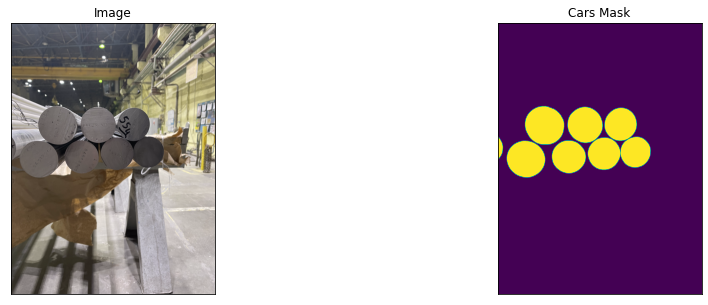

In [8]:
image, mask = train_dataset_vis[0] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

# Инициализация и обучение модели
Обучим модель и проверим ее качество.

In [9]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
model = smp.Unet(
    encoder_name=ENCODER,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=ENCODER_WEIGHTS,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,
    activation=ACTIVATION
)

In [11]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-3),
])

In [12]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [13]:
max_score = 0
iou_hist = []

optimizer.param_groups[0]['lr'] = 1e-3

epochs = 100 # for testing purposes
for i in range(0, epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    iou_hist.append(valid_logs['iou_score'])
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/home/jorji/jet-project/models/_ocr_model.pth')
        print('Model saved!')
    if i == 45:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')
    if i == 80:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s, dice_loss - 0.9096, iou_score - 2.054e-05]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s, dice_loss - 0.7592, iou_score - 0.1108]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s, dice_loss - 0.3623, iou_score - 0.5304]
Model saved!

Epoch: 3
valid: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s, dice_loss - 0.6403, iou_score - 0.2263]

Epoch: 4
valid: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s, dice_loss - 0.3337, iou_score - 0.5138]

Epoch: 5
valid: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, dice_loss - 0.26, iou_score - 0.6221]  
Model saved!

Epoch: 6
valid: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s, dice_loss - 0.3177, iou_score - 0.553]

Epoch: 7
valid: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s, dice_loss - 0.2699, iou_score - 0.6111]

Epoch: 8
valid: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s, dice_loss - 0.2822, iou_score - 0.5934]

Epoch: 9
valid: 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


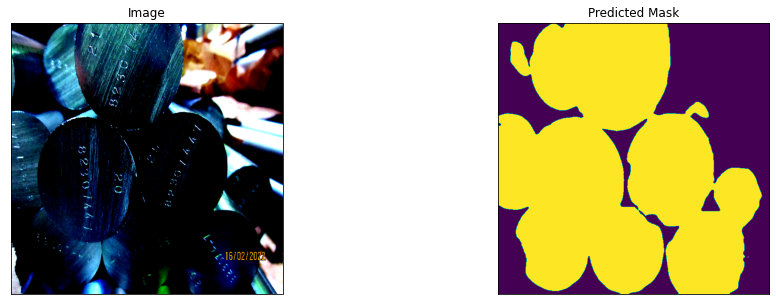

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


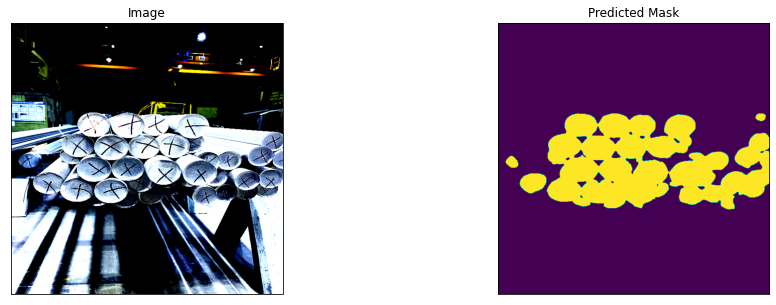

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


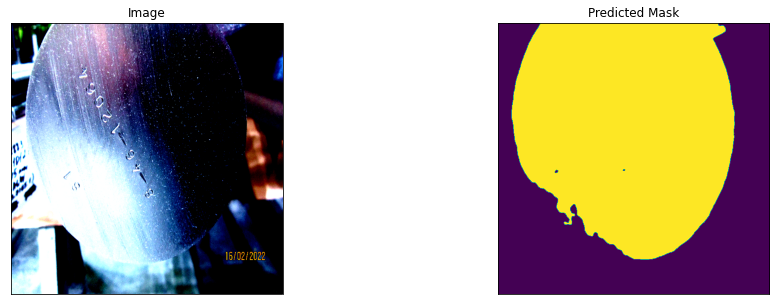

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


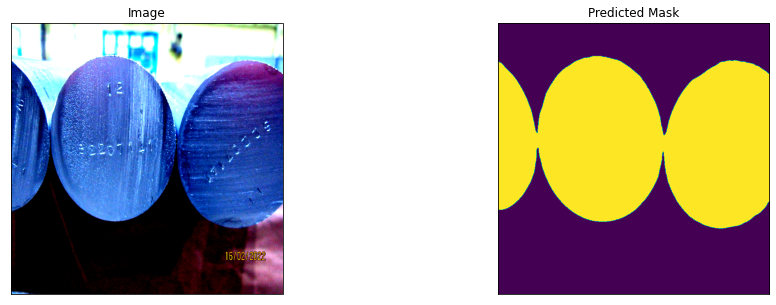

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


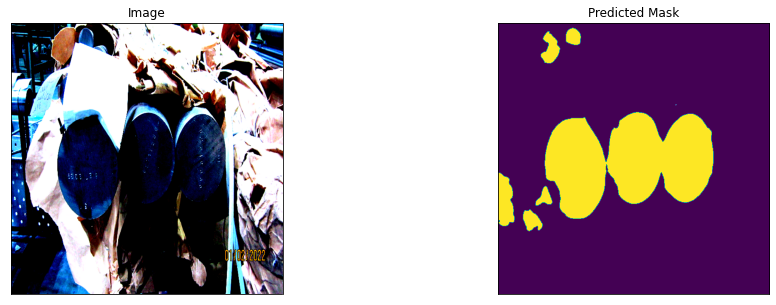

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


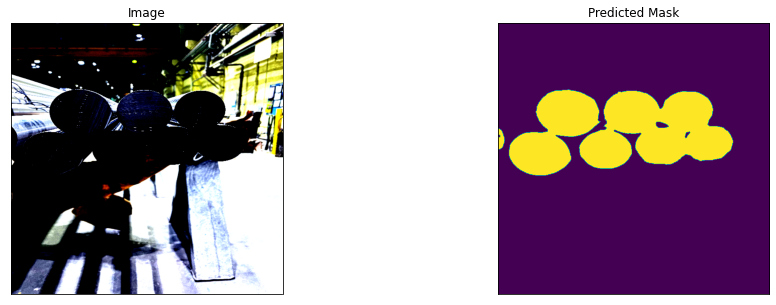

In [14]:
# порог по вероятности, выше которого считаем пиксель = 1 (пруток)
p = 0.5

for img_path in dataset_test.images:
    img = preprocessing_fn(plt.imread(img_path))
    image = get_validation_augmentation()(image=img)['image']
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    x_tensor = x_tensor.permute(0, 3, 1,2)
    x_tensor = x_tensor.to(torch.float32)

    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask > p).squeeze().cpu().numpy()
    # pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image, 
        predicted_mask=pr_mask
    )